# Accessing Variables in Jets & MC

This short notebook shows how to access jets and MC particles in a dataset so that you can get the awkward information local.

Some of this code is common and may be best put into files to be separate libraries or modules.

## Datasets

We'll have two datasets here (we can get more if we want).

* `dijet` - These are simple QCD 2-jet production runs. These are very much Standard Model events. The dataset is actually HUGE. I've limited it to 20 files worth of events, but you can increase it if you want. But the first query will take a lot longer if you do that!
* `llp` - These are Hidden Valley (a type of Hidden Sector) simulation. They contain the long lived particles we are interested in. And this is where you'll do most of your testing.

In [8]:
ds_dijet_rucio = "rucio://mc16_13TeV.361022.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ2W.deriv.DAOD_EXOT15.e3668_s3126_r9364_r9315_p4696?files=20&get=available"

Create the datasets

In [9]:
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21, calib_tools
ds_dijet = SXDSAtlasxAODR21(ds_dijet_rucio)

## Accessing the AntiKt4 jets & PFLow jets


Everything in ATLAS is stored as a collection _name_. There are two for the particle flow and the antikt4 jets:

In [10]:
jets_pflow_name = "AntiKt4EMPFlowJets"
jets_antikt_name = "AntiKt4EMTopoJets"

Lets get the two types of jets.

In [11]:
jets_pflow = (ds_dijet.Select(lambda e: e.Jets(uncalibrated_collection=jets_pflow_name))
    .Select(lambda e: e.Where(lambda j: (j.pt() / 1000) > 30))
    .Select(lambda e: e.Select(lambda j: (j.pt() / 1000)))
    .AsAwkwardArray("JetPt")
    .value()
)

jets_antikt = (ds_dijet.Select(lambda e: e.Jets(uncalibrated_collection=jets_antikt_name))
    .Select(lambda e: e.Where(lambda j: (j.pt() / 1000) > 30))
    .Select(lambda e: e.Select(lambda j: (j.pt() / 1000)))
    .AsAwkwardArray("JetPt")
    .value()
)

Do a quick plot of the number of jets in each event that is about 30 GeV:

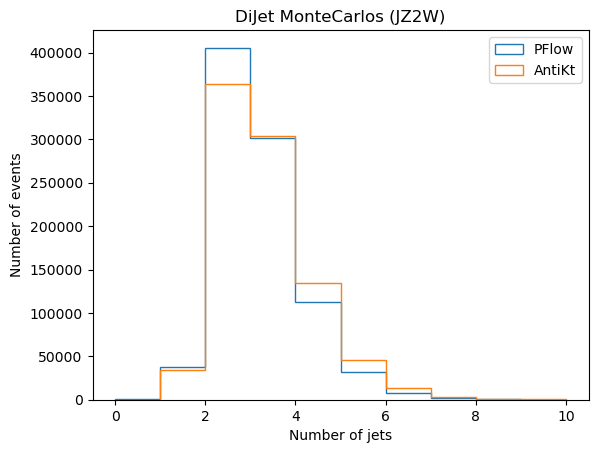

In [12]:
from matplotlib import pyplot as plt
import awkward as ak

plt.hist(ak.count(jets_pflow['JetPt'], axis=-1), bins=10, range=(0, 10), label='PFlow', histtype='step')
plt.hist(ak.count(jets_antikt['JetPt'], axis=-1), bins=10, range=(0, 10), label='AntiKt', histtype='step')
plt.xlabel('Number of jets')
plt.ylabel('Number of events')
plt.title('DiJet MonteCarlos (JZ2W)')
plt.legend()
plt.show()


## Monte Carlo Particles

**NOTHING BELOW HERE WORKS**

Next, lets go after the MC particles. For this we need to look at an actual LLP dataset. Every particle has an ID, and for the LLP it is number 35. And that is the only one we are interested in looking at.

In [ ]:
llp_particles = (ds_dijet.SelectMany(lambda e: e.TruthParticles("TruthParticles"))
    .Where(lambda p: p.pt()/1000.0 > 5)
    .Select(lambda p:{
        'pt': p.pt()/1000.0,
        'eta': p.eta(),
        'phi': p.phi(),
    })
    .AsAwkwardArray()
    .value()
)

In [ ]:
llp_particles

In [ ]:
all_particles = (ds_dijet
                 .SelectMany(lambda e: e.TruthParticles("TruthParticles"))
                 .Where(lambda tp: (tp.pt() / 1000) > 10)
                 .Select(lambda tp: {
                         'pt': tp.pt() / 1000.0,
                         'pdgId': abs(tp.pdgId()),
                 })
                 .AsAwkwardArray()
                 .value())